# Set-up

In [1]:
# Importing libraries
import os
import glob
import json
import random

import numpy as np
import pandas as pd
import pyBigWig

import matplotlib.pyplot as plt
import seaborn as sns

def plot_tracks(tracks, interval, height=1.5, colors=None, sharey=False):
  _, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True, sharey=sharey)
  if not isinstance(axes, np.ndarray):
    axes = [axes]
  for ax, (title, y) in zip(axes, tracks.items()):
    if colors is not None:
      ax.fill_between(np.linspace(interval["start"], interval["end"], num=len(y)), y, color=colors[title])
    else:
      ax.fill_between(np.linspace(interval["start"], interval["end"], num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(f"{interval['chrom']}:{interval['start']}-{interval['end']}")
  plt.tight_layout()

def plot_tracks_from_locus(locus, bws, colors, sharey=False):
    chrom, coord = locus.split(":")
    start, end = coord.split("-")
    start, end = int(start), int(end)
    interval = {"chrom": chrom, "start": int(start), "end": int(end)}
    tracks = {k: np.nan_to_num(np.array(bw.values(chrom, start, end))) for k, bw in bws.items()}
    plot_tracks(tracks, interval, height=1.5, colors=colors, sharey=sharey)

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# Paths
path_fragments_counts = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/4_integration/atac/pseudobulk/rna_celltype/12-1/fragments/frag_counts.tsv"
path_narrowPeaks_dir = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/5_peak_analysis/peak_calls/rna_celltype/12-1/snapatac2"
path_bc_metadata = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/5_peak_analysis/peak_calls/rna_celltype/12-1/snapatac2/integrate/round_1/cell_metadata.tsv"
path_out = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k"

# Data overview

In [3]:
# Load fragment counts to start
fragment_counts = pd.read_csv(path_fragments_counts, sep="\t", index_col=0).to_dict()["fragments"]

# Get number of narrowPeaks per celltype
narrowPeaks = {}
for f in glob.glob(f"{path_narrowPeaks_dir}/*.narrowPeak"):
    celltype = os.path.basename(f).split(".narrowPeak")[0]
    narrowPeaks[celltype] = len(pd.read_csv(f, sep="\t", header=None))
narrowPeaks = {k: v for k, v in narrowPeaks.items() if "top" not in k}

# Get number of cells per celltype
bc_metadata = pd.read_csv(path_bc_metadata, sep="\t", index_col=0)
cells_per_celltype = bc_metadata.groupby("rna_celltype").size()

# Make a df that looks like this: Cell Type	Number of Barcodes	Number of Fragments	Number of Peak Calls
df = pd.DataFrame({
    "Number of Barcodes": cells_per_celltype,
    "Number of Fragments": pd.Series(fragment_counts),
    "Number of Peak Calls": pd.Series(narrowPeaks)
})
df.index.name = "Cell Type"
df = df.sort_index(key=lambda x: x.str.lower())

# Save
df.to_csv(f"{path_out}/summary/data_overview.csv")

# Check
df

/tmp/ipykernel_1050033/3760597622.py:12: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  bc_metadata = pd.read_csv(path_bc_metadata, sep="\t", index_col=0)


,Number of Barcodes,Number of Fragments,Number of Peak Calls
Cell Type,,,
SC.alpha,71011,1002541303,374513
SC.beta,53686,874485670,419437
SC.delta,1356,20421056,109892
SC.EC,43549,695095274,421599


# Bias model overview

In [4]:
# Count up negatives used for each celltype and fold
negatives = {}
for f in glob.glob(f"{path_out}/*/fold_*/negatives/*.bed"):
    celltype = os.path.basename(f).split("_negatives.bed")[0]
    fold = f.split("/")[-3]
    if celltype not in negatives:
        negatives[celltype] = {}
    negatives[celltype][fold] = len(pd.read_csv(f, sep="\t", header=None))

# Turn into long form with celltype, fold, and count
negatives_df = pd.DataFrame(negatives).T.reset_index().melt(id_vars="index", var_name="fold", value_name="Number of Negatives")
negatives_df.columns = ["Cell Type", "Fold", "Number of Negatives"]
negatives_df = negatives_df.sort_values("Cell Type", key=lambda x: x.str.lower())

# Find all data parameters
bias_data_params = pd.DataFrame()
for f in glob.glob(f"{path_out}/*/*/bias_model/*/logs/*_bias_data_params.tsv"):
    celltype = f.split("/")[-6]
    fold = f.split("/")[-5]
    beta = f.split("/")[-3]
    curr_df = pd.read_csv(f, sep="\t", index_col=0, header=None).T
    curr_df["celltype"] = celltype
    curr_df["beta"] = beta
    curr_df["fold"] = fold
    bias_data_params = bias_data_params.append(curr_df)

# Find all jsons with performance metrics
bias_metrics = pd.DataFrame()
for f in glob.glob(f"{path_out}/*/*/bias_model/*/evaluation/*_bias_metrics.json"):
    celltype = f.split("/")[-6]
    fold = f.split("/")[-5]
    beta = f.split("/")[-3]
    with open(f, "r") as f:
        curr_dict = json.load(f)
    curr_dict = {f"{k1}_{k2}_{k3}": v3 for k1, v1 in curr_dict.items() for k2, v2 in v1.items() for k3, v3 in v2.items()}
    curr_df = pd.DataFrame(curr_dict, index=[0])
    curr_df["celltype"] = celltype
    curr_df["beta"] = beta
    curr_df["fold"] = fold
    bias_metrics = bias_metrics.append(curr_df)

# Merge dfs
bias = bias_data_params.merge(bias_metrics, on=["celltype", "beta", "fold"])
bias = bias.merge(negatives_df, left_on=["celltype", "fold"], right_on=["Cell Type", "Fold"])

# Clean up dataframe
bias_clean = bias[["celltype", "beta", "fold", "Number of Negatives", "counts_metrics_nonpeaks_pearsonr", "counts_metrics_peaks_pearsonr", "profile_metrics_nonpeaks_median_jsd", "profile_metrics_peaks_median_jsd"]]
bias_clean.columns = ["Cell Type", "Beta", "Fold", "Number of Negatives", "Bias Model Pearson r in Non-Peaks", "Bias Model Pearson r in Peaks", "Bias Model JSD in Non-Peaks", "Bias Model JSD in Peaks"]
bias_clean["lower_celltype"] = bias_clean["Cell Type"].str.lower()
bias_clean = bias_clean.sort_values(["lower_celltype", "Beta", "Fold"])
bias_clean = bias_clean[bias_clean["Beta"] == "0.8"]
bias_clean["Number of Negatives"] = bias_clean["Number of Negatives"].astype(int)
bias_clean["Bias Model Pearson r in Non-Peaks"] = bias_clean["Bias Model Pearson r in Non-Peaks"].round(2)
bias_clean["Bias Model Pearson r in Peaks"] = bias_clean["Bias Model Pearson r in Peaks"].round(2)
bias_clean["Bias Model JSD in Non-Peaks"] = bias_clean["Bias Model JSD in Non-Peaks"].round(2)
bias_clean["Bias Model JSD in Peaks"] = bias_clean["Bias Model JSD in Peaks"].round(2)
bias_clean = bias_clean.drop(columns="lower_celltype")

# Save
bias_clean.to_csv(f"{path_out}/summary/bias_metrics.csv", index=False)

# Check it
bias_clean.head()

/tmp/ipykernel_1050033/1226335671.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bias_data_params = bias_data_params.append(curr_df)
/tmp/ipykernel_1050033/1226335671.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bias_data_params = bias_data_params.append(curr_df)
/tmp/ipykernel_1050033/1226335671.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bias_data_params = bias_data_params.append(curr_df)
/tmp/ipykernel_1050033/1226335671.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bias_data_params = bias_data_params.append(curr_df)
/tmp/ipykernel_1050033/1226335671.py:25: FutureWarning: The frame.append method is depre

,Cell Type,Beta,Fold,Number of Negatives,Bias Model Pearson r in Non-Peaks,Bias Model Pearson r in Peaks,Bias Model JSD in Non-Peaks,Bias Model JSD in Peaks
0,SC.alpha,0.8,fold_0,446384,0.55,-0.25,0.47,0.34
8,SC.beta,0.8,fold_0,447067,0.50,-0.35,0.47,0.35
11,SC.beta,0.8,fold_1,449083,0.35,-0.44,0.48,0.34
9,SC.beta,0.8,fold_2,455269,0.40,-0.41,0.48,0.35
5,SC.beta,0.8,fold_3,446446,0.47,-0.36,0.47,0.34


# ChromBPNet model overview

In [5]:
# Same for full model
model_params = pd.DataFrame()
for f in glob.glob(f"{path_out}/*/*/chrombpnet/*/logs/*_model_params.tsv"):
    celltype = f.split("/")[-6]
    fold = f.split("/")[-5]
    beta = f.split("/")[-3]
    curr_df = pd.read_csv(f, sep="\t", index_col=0, header=None).T
    curr_df["celltype"] = celltype
    curr_df["beta"] = beta
    curr_df["fold"] = fold
    model_params = model_params.append(curr_df)

# Metrics
model_metrics = pd.DataFrame()
for f in glob.glob(f"{path_out}/*/*/chrombpnet/*/evaluation/chrombpnet_metrics.json"):
    celltype = f.split("/")[-6]
    fold = f.split("/")[-5]
    beta = f.split("/")[-3]
    with open(f, "r") as f:
        curr_dict = json.load(f)
    curr_dict = {f"{k1}_{k2}_{k3}": v3 for k1, v1 in curr_dict.items() for k2, v2 in v1.items() for k3, v3 in v2.items()}
    curr_df = pd.DataFrame(curr_dict, index=[0])
    curr_df["celltype"] = celltype
    curr_df["beta"] = beta
    curr_df["fold"] = fold
    model_metrics = model_metrics.append(curr_df)

# merge model_params and model_metrics
model = model_params.merge(model_metrics, on=["celltype", "beta", "fold"])

# Clean up dataframe
model_clean = model[["celltype", "beta", "fold", "counts_metrics_peaks_pearsonr", "profile_metrics_peaks_median_jsd"]]
model_clean.columns = ["Cell Type", "Beta", "Fold", "ChromBPNet Pearson r in Peaks", "ChromBPNet Median JSD in Peaks"]
model_clean["lower_celltype"] = model_clean["Cell Type"].str.lower()
model_clean = model_clean.sort_values(["lower_celltype", "Beta", "Fold"])
model_clean = model_clean.drop(columns="lower_celltype")
model_clean["ChromBPNet Pearson r in Peaks"] = model_clean["ChromBPNet Pearson r in Peaks"].round(2)
model_clean["ChromBPNet Median JSD in Peaks"] = model_clean["ChromBPNet Median JSD in Peaks"].round(2)

# Add columns for Predictions generated and Contributions generated (leave blank for now)
model_clean["Predictions Generated"] = ""
model_clean["Contributions Generated"] = ""

# Save
model_clean.to_csv(f"{path_out}/summary/model_metrics.csv", index=False)

# Check it
model_clean.head()

/tmp/ipykernel_1050033/565291174.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_params = model_params.append(curr_df)
/tmp/ipykernel_1050033/565291174.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_params = model_params.append(curr_df)
/tmp/ipykernel_1050033/565291174.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_params = model_params.append(curr_df)
/tmp/ipykernel_1050033/565291174.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_params = model_params.append(curr_df)
/tmp/ipykernel_1050033/565291174.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas

,Cell Type,Beta,Fold,ChromBPNet Pearson r in Peaks,ChromBPNet Median JSD in Peaks,Predictions Generated,Contributions Generated
0,SC.alpha,0.8,fold_0,0.81,0.29,,
3,SC.alpha,0.8,fold_1,0.82,0.29,,
4,SC.alpha,0.8,fold_2,0.82,0.29,,
1,SC.alpha,0.8,fold_3,0.81,0.29,,
2,SC.alpha,0.8,fold_4,0.82,0.29,,


# Plots

In [6]:
celltype_colors = {
    "SC.beta": "#2a9df4",
    "SC.alpha": "#967bb6",
    "SC.EC": "#ff7f50",
    "SC.delta": "#dc143c"
}
celltype_order = ["SC.alpha", "SC.beta", "SC.EC"]

/tmp/ipykernel_1050033/4231205811.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cell Type", y="ChromBPNet Pearson r in Peaks", data=model_clean, palette=celltype_colors, order=celltype_order, ax=ax)
/tmp/ipykernel_1050033/4231205811.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="Cell Type", y="ChromBPNet Pearson r in Peaks", data=model_clean, palette=celltype_colors, order=celltype_order, ax=ax)


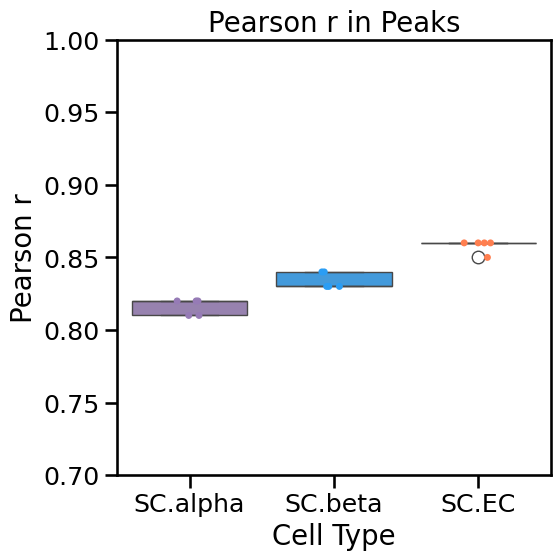

In [7]:
# ChromBPNet Pearson r in Peak boxplot
with sns.plotting_context("talk", font_scale=1.1):
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.boxplot(x="Cell Type", y="ChromBPNet Pearson r in Peaks", data=model_clean, palette=celltype_colors, order=celltype_order, ax=ax)
    sns.stripplot(x="Cell Type", y="ChromBPNet Pearson r in Peaks", data=model_clean, palette=celltype_colors, order=celltype_order, ax=ax)
    ax.set_title("Pearson r in Peaks")
    ax.set_ylabel("Pearson r")
    ax.set_xlabel("Cell Type")
    ax.set_ylim(0.7, 1)
    plt.tight_layout()
    plt.savefig(f"{path_out}/summary/ChromBPNet_Pearson_r_in_Peaks.png")
    plt.show()


/tmp/ipykernel_1050033/322864433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cell Type", y="ChromBPNet Median JSD in Peaks", data=model_clean, palette=celltype_colors, order=celltype_order, ax=ax)
/tmp/ipykernel_1050033/322864433.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="Cell Type", y="ChromBPNet Median JSD in Peaks", data=model_clean, palette=celltype_colors, order=celltype_order, ax=ax)


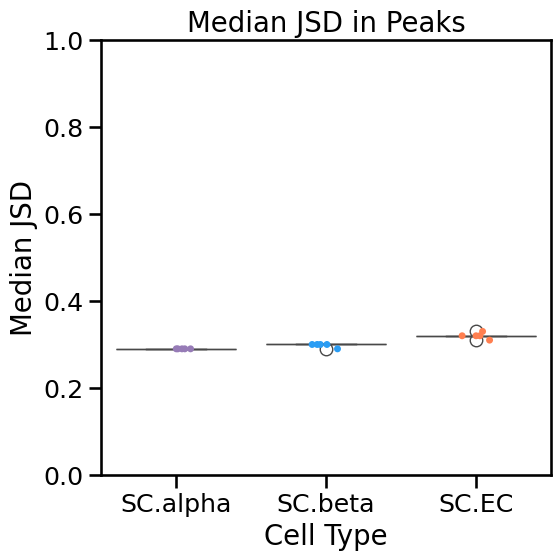

In [8]:
# ChromBPNet Median JSD in Peak boxplot
with sns.plotting_context("talk", font_scale=1.1):
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.boxplot(x="Cell Type", y="ChromBPNet Median JSD in Peaks", data=model_clean, palette=celltype_colors, order=celltype_order, ax=ax)
    sns.stripplot(x="Cell Type", y="ChromBPNet Median JSD in Peaks", data=model_clean, palette=celltype_colors, order=celltype_order, ax=ax)
    ax.set_title("Median JSD in Peaks")
    ax.set_ylabel("Median JSD")
    ax.set_xlabel("Cell Type")
    ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.savefig(f"{path_out}/summary/ChromBPNet_Median_JSD_in_Peaks.png")
    plt.show()

# Model browser sessions

In [148]:
# Load cell id colors
cellid_colors = {
    'SC.alpha': '#967bb6',
    'SC.beta': '#2a9df4',
    'SC.delta': '#dc143c',
    'SC.EC': '#ff7f50',
}
order = ["SC.alpha", "SC.beta", "SC.delta", "SC.EC"]

In [149]:
celltypes = ["SC.beta"]
bucket = "gs://2025_01_06"

In [150]:
path_narrowPeaks = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k"
path_tn5_df = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/4_integration/atac/pseudobulk/rna_celltype/12-1/count_bws/count_bw_file_paths.tsv"
path_prediction_bigwigs = "/cellar/users/aklie/projects/igvf/sc-islet-design/results/prediction_bigwigs"

## ATAC narrowPeak files

In [151]:
# Get narrowPeaks_dict
narrowPeaks_dict = {}
for f in glob.glob(f"{path_narrowPeaks}/*/*.narrowPeak"):
    celltype = os.path.basename(f).split(".top250k.narrowPeak")[0]
    narrowPeaks_dict[celltype] = f
    narrowPeaks_dict = {k: v for k, v in narrowPeaks_dict.items() if k in celltypes}
narrowPeaks_dict

{'SC.beta': '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k/SC.beta/SC.beta.top250k.narrowPeak'}

In [152]:
%%bash -s "$path_narrowPeaks" "$path_out/browser/narrowPeaks"
source activate chrombpnet
mkdir -p $2
for f in $1/*/*.narrowPeak; do
  celltype=$(basename $f .narrowPeak)
  sort_bed=${2}/$(basename $f .narrowPeak).sorted.narrowPeak
  if [ -f $sort_bed.gz ]; then
    echo "$sort_bed.gz exists, skipping"
    continue
  fi
  echo "Processing $f"
  sort -k1,1 -k2,2n $f > $sort_bed
  bgzip $sort_bed
  tabix -p bed ${sort_bed}.gz
done

/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k/browser/narrowPeaks/SC.alpha.top250k.sorted.narrowPeak.gz exists, skipping
/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k/browser/narrowPeaks/SC.beta.top250k.sorted.narrowPeak.gz exists, skipping
/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k/browser/narrowPeaks/SC.beta.top250k.sorted.narrowPeak.gz exists, skipping
/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k/browser/narrowPeaks/SC.delta.top250k.sorted.narrowPeak.gz exists, skipping
/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k/browser/narrowPeaks/SC.EC.top250k.sorted.narrowPeak.gz exists, skipping


In [154]:
# Secure copy all both files to bucket
for f in glob.glob(f"{path_out}/browser/narrowPeaks/*.sorted.narrowPeak.gz*"):
    if not any([celltype in f for celltype in celltypes]):
        continue
    basename = os.path.basename(f)
    cmd = f"gsutil cp {f} {bucket}/{basename}"
    print(cmd)
    #os.system(cmd)

# DataFrame
bed_df = pd.DataFrame({
    "url": [f"https://storage.googleapis.com/2025_01_06/{celltype}.sorted.narrowPeak.gz" for celltype in celltypes],
    "name": celltypes,
    "celltype": [celltype for celltype in bw_dict.keys() if celltype in celltypes],
    "type": "bed",
    "color": [cellid_colors[celltype] for celltype in celltypes]
})

# Transform DataFrame to the desired bed structure
bed_tracks = [
    {
        "type": row["type"],
        "url": row["url"],
        "name": row["name"],
        "options": {
            "color": row["color"],
        },
        "showOnHubLoad": True,
    }
    for _, row in bed_df.iterrows()
]

# add in the 
bed_tracks

gsutil cp /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k/browser/narrowPeaks/SC.beta.top250k.sorted.narrowPeak.gz gs://2025_01_06/SC.beta.top250k.sorted.narrowPeak.gz
gsutil cp /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k/browser/narrowPeaks/SC.beta.top250k.sorted.narrowPeak.gz.tbi gs://2025_01_06/SC.beta.top250k.sorted.narrowPeak.gz.tbi


[{'type': 'bed',
  'url': 'https://storage.googleapis.com/2025_01_06/SC.beta.sorted.narrowPeak.gz',
  'name': 'SC.beta',
  'options': {'color': '#2a9df4'},
  'showOnHubLoad': True}]

## ATAC raw insertion counts BigWigs

{'SC.beta': <pyBigWig.bigWigFile at 0x1554fdb5d740>,
 'SC.EC': <pyBigWig.bigWigFile at 0x15550490bb10>,
 'SC.alpha': <pyBigWig.bigWigFile at 0x1555067f6460>,
 'SC.delta': <pyBigWig.bigWigFile at 0x1555067f6b20>}

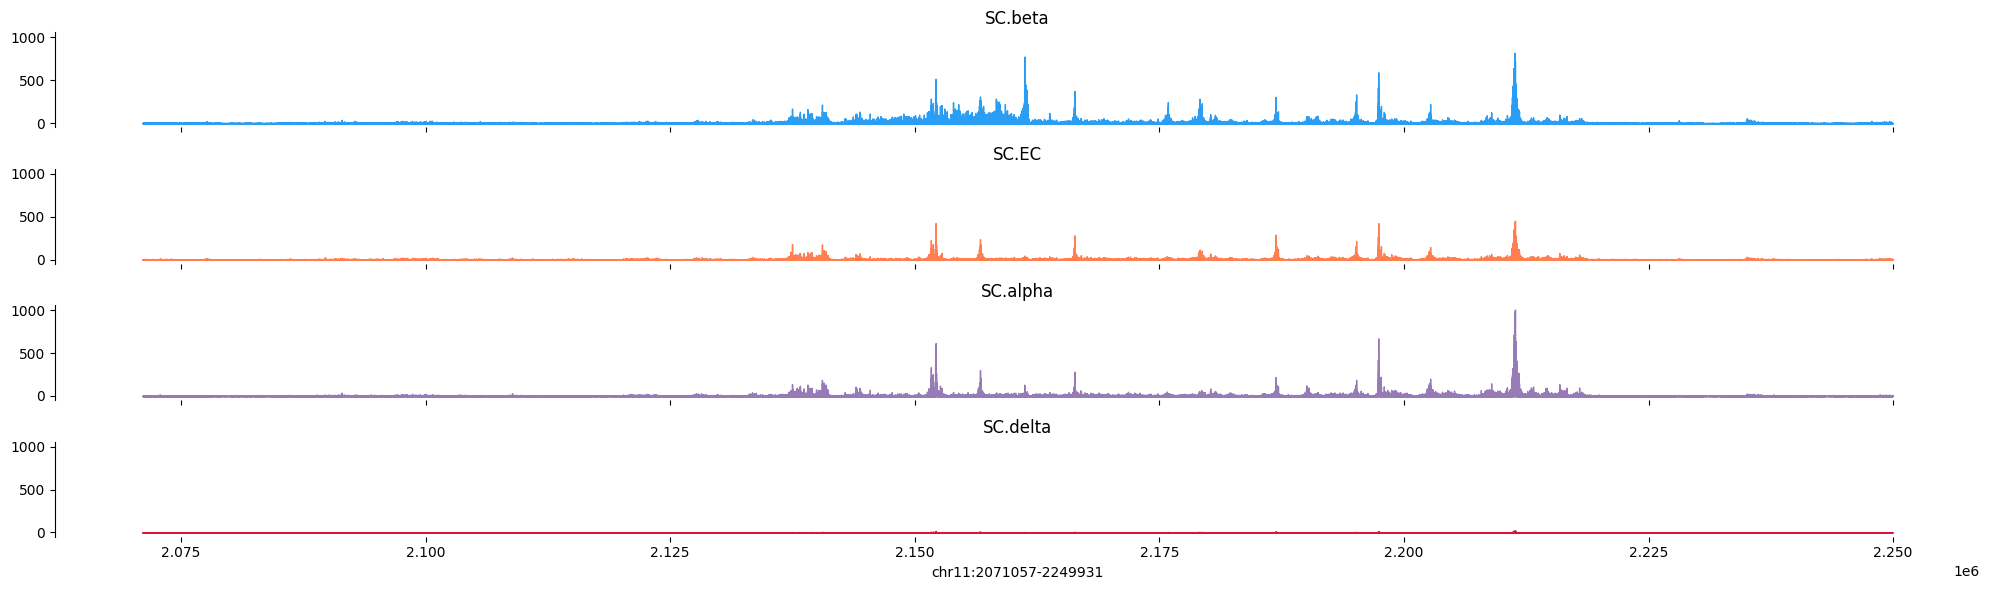

In [155]:
df = pd.read_csv(path_tn5_df, sep="\t", header=None, names=["path", "celltype"])
bw_dict = {row["celltype"]: pyBigWig.open(row["path"]) for _, row in df.iterrows()}
locus = "chr11:2071057-2249931"
plot_tracks_from_locus(locus, bw_dict, cellid_colors, sharey=True)
bw_dict

In [157]:
# Secure copy all bigwig files to bucket
for _, row in df.iterrows():
    path = row["path"]
    celltype = row["celltype"]
    if celltype not in celltypes:
        continue
    cmd = f"gsutil cp {path} {bucket}/{celltype}_unstranded.tn5_counts.bw"
    print(cmd)
    #os.system(cmd)

# Create a dataframe with the bigwig files in the bucket
tn5_df = pd.DataFrame({
    "url": [f"https://storage.googleapis.com/2025_01_06/{celltype}_unstranded.tn5_counts.bw" for celltype in bw_dict.keys()],
    "name": [f"{celltype}_unstranded.tn5_counts" for celltype in bw_dict.keys()],
    "celltype": [celltype for celltype in bw_dict.keys()],
    "color": [cellid_colors[celltype] for celltype in bw_dict.keys()],
    "type": "bigwig",
})
tn5_df = tn5_df[tn5_df["celltype"].isin(celltypes)]

# Transform DataFrame to the desired tn5 structure
tn5_tracks = [
    {
        "type": row["type"],
        "url": row["url"],
        "name": row["name"],
        "options": {
            "color": row["color"],
        },
        "showOnHubLoad": True,
    }
    for _, row in tn5_df.iterrows()
]

# add in the 
tn5_tracks

gsutil cp /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/4_integration/atac/pseudobulk/rna_celltype/12-1/count_bws/SC.beta_unstranded.bw gs://2025_01_06/SC.beta_unstranded.tn5_counts.bw


[{'type': 'bigwig',
  'url': 'https://storage.googleapis.com/2025_01_06/SC.beta_unstranded.tn5_counts.bw',
  'name': 'SC.beta_unstranded.tn5_counts',
  'options': {'color': '#2a9df4'},
  'showOnHubLoad': True}]

# ATAC Prediction BigWigs

In [158]:
# Load prediction bigwigs
df_prediction_bigwigs = pd.DataFrame(prediction_bigwigs, columns=["path"])
df_prediction_bigwigs["celltype"] = df_prediction_bigwigs["path"].apply(lambda x: x.split("/")[-1].split("_")[0])
df_prediction_bigwigs["name"] = df_prediction_bigwigs["path"].apply(lambda x: x.split("/")[-1])
df_prediction_bigwigs

# Secure copy all bigwig files to bucket
for _, row in df_prediction_bigwigs.iterrows():
    path = row["path"]
    celltype = row["celltype"]
    name = row["name"]
    if celltype not in celltypes:
        continue
    cmd = f"gsutil cp {path} gs://2025_01_06/{name}"
    print(cmd)
    #os.system(cmd)

# Create a dataframe with the bigwig files in the bucket
prediction_df = pd.DataFrame({
    "url": [f"https://storage.googleapis.com/2025_01_06/{name}" for name in df_prediction_bigwigs["name"]],
    "name": df_prediction_bigwigs["name"],
    "celltype": df_prediction_bigwigs["celltype"],
    "color": [cellid_colors[celltype] for celltype in df_prediction_bigwigs["celltype"]],
    "type": "bigwig",
})
prediction_df = prediction_df[prediction_df["celltype"].isin(celltypes)]

# Transform DataFrame to the desired prediction structure
prediction_tracks = [
    {
        "type": row["type"],
        "url": row["url"],
        "name": row["name"],
        "options": {
            "color": row["color"],
        },
        "showOnHubLoad": True,
    }
    for _, row in prediction_df.iterrows()
]
prediction_tracks

gsutil cp /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k/SC.beta/average/predictions/SC.beta_chrombpnet.bw gs://2025_01_06/SC.beta_chrombpnet.bw
gsutil cp /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k/SC.beta/average/predictions/SC.beta_chrombpnet_nobias.bw gs://2025_01_06/SC.beta_chrombpnet_nobias.bw
gsutil cp /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k/SC.beta/average/predictions/SC.beta_bias.bw gs://2025_01_06/SC.beta_bias.bw


[{'type': 'bigwig',
  'url': 'https://storage.googleapis.com/2025_01_06/SC.beta_chrombpnet.bw',
  'name': 'SC.beta_chrombpnet.bw',
  'options': {'color': '#2a9df4'},
  'showOnHubLoad': True},
 {'type': 'bigwig',
  'url': 'https://storage.googleapis.com/2025_01_06/SC.beta_chrombpnet_nobias.bw',
  'name': 'SC.beta_chrombpnet_nobias.bw',
  'options': {'color': '#2a9df4'},
  'showOnHubLoad': True},
 {'type': 'bigwig',
  'url': 'https://storage.googleapis.com/2025_01_06/SC.beta_bias.bw',
  'name': 'SC.beta_bias.bw',
  'options': {'color': '#2a9df4'},
  'showOnHubLoad': True}]

## ATAC Contribution BigWigs

In [163]:
# Load contribution bigwigs
contribution_bigwigs = glob.glob(f"{path_out}/*/average/contributions/*.bw")
df_contribution_bigwigs = pd.DataFrame(contribution_bigwigs, columns=["path"])
df_contribution_bigwigs["celltype"] = df_contribution_bigwigs["path"].apply(lambda x: x.split("/")[-4])
df_contribution_bigwigs["name"] = df_contribution_bigwigs["path"].apply(lambda x: x.split("/")[-1])

# Secure copy all bigwig files to bucket
for _, row in df_contribution_bigwigs.iterrows():
    path = row["path"]
    celltype = row["celltype"]
    name = row["name"]
    cmd = f"gsutil cp {path} gs://2025_01_06/{name}"
    if celltype not in celltypes:
        continue
    print(cmd)
    #os.system(cmd)

# Create a dataframe with the bigwig files in the bucket
contribution_df = pd.DataFrame({
    "url": [f"https://storage.googleapis.com/2025_01_06/{name}" for name in df_contribution_bigwigs["name"]],
    "name": df_contribution_bigwigs["name"],
    "celltype": df_contribution_bigwigs["celltype"],
    "type": "dynseq",
    "color": [cellid_colors[celltype] for celltype in df_contribution_bigwigs["celltype"]]
})
contribution_df = contribution_df[contribution_df["celltype"].isin(celltypes)]

# Transform DataFrame to the desired contribution structure
contribution_tracks = [
    {
        "type": row["type"],
        "url": row["url"],
        "name": row["name"],
        "options": {
            "color": row["color"],
        },
        "showOnHubLoad": True,
    }
    for _, row in contribution_df.iterrows()
]
contribution_tracks

gsutil cp /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k/SC.beta/average/contributions/SC.beta_counts.bw gs://2025_01_06/SC.beta_counts.bw
gsutil cp /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k/SC.beta/average/contributions/SC.beta_profile.bw gs://2025_01_06/SC.beta_profile.bw


[{'type': 'dynseq',
  'url': 'https://storage.googleapis.com/2025_01_06/SC.beta_counts.bw',
  'name': 'SC.beta_counts.bw',
  'options': {'color': '#2a9df4'},
  'showOnHubLoad': True},
 {'type': 'dynseq',
  'url': 'https://storage.googleapis.com/2025_01_06/SC.beta_profile.bw',
  'name': 'SC.beta_profile.bw',
  'options': {'color': '#2a9df4'},
  'showOnHubLoad': True}]

## Motif hits

In [189]:
%%bash -s "$path_out/*/average/motifs/hits/*/hits.bed" "$path_out/browser/motif_hits"
source activate chrombpnet
mkdir -p $2
for f in $1; do
    celltype=$(echo $f | cut -d'/' -f11)
    head=$(echo $f | cut -d'/' -f15)
    name=${celltype}_${head}_motif_hits.bed
    sort_bed=${2}/${name}.sorted.bed
    if [ -f $sort_bed.gz ]; then
        echo "$sort_bed.gz exists, skipping"
        continue
    fi
    echo "Processing $f"
    sort -k1,1 -k2,2n $f > $sort_bed
    bgzip $sort_bed
    tabix -p bed ${sort_bed}.gz
done

Processing /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k/SC.beta/average/motifs/hits/counts/hits.bed
Processing /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k/SC.beta/average/motifs/hits/profile/hits.bed


In [198]:
# Secure copy all bigwig files to bucket
df_motif_hits = []
for f in glob.glob(f"{path_out}/browser/motif_hits/*.sorted.bed.gz*"):
    if not any([celltype in f for celltype in celltypes]):
        continue
    basename = os.path.basename(f)
    cmd = f"gsutil cp {f} {bucket}/{basename}"
    print(cmd)
    #os.system(cmd)
    if not basename.endswith(".gz"):
        continue
    df_motif_hits.append({
        "url": f"https://storage.googleapis.com/2025_01_06/{basename}",
        "name": basename,
        "celltype": basename.split("_")[0],
        "type": "bed",
        "color": cellid_colors[basename.split("_")[0]]
    })
df_motif_hits = pd.DataFrame(df_motif_hits)

# Transform DataFrame to the desired motif structure
motif_tracks = [
    {
        "type": row["type"],
        "url": row["url"],
        "name": row["name"],
        "options": {
            "color": row["color"],
        },
        "showOnHubLoad": True,
    }
    for _, row in df_motif_hits.iterrows()
]
motif_tracks

gsutil cp /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k/browser/motif_hits/SC.beta_profile_motif_hits.bed.sorted.bed.gz.tbi gs://2025_01_06/SC.beta_profile_motif_hits.bed.sorted.bed.gz.tbi
gsutil cp /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k/browser/motif_hits/SC.beta_counts_motif_hits.bed.sorted.bed.gz.tbi gs://2025_01_06/SC.beta_counts_motif_hits.bed.sorted.bed.gz.tbi
gsutil cp /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k/browser/motif_hits/SC.beta_profile_motif_hits.bed.sorted.bed.gz gs://2025_01_06/SC.beta_profile_motif_hits.bed.sorted.bed.gz
gsutil cp /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k/browser/motif_hits/SC.beta_counts_motif_hits.bed.sorted.bed.gz gs://2025_01_06/SC.beta_counts_motif_hits.bed.sorted.bed.gz


[{'type': 'bed',
  'url': 'https://storage.googleapis.com/2025_01_06/SC.beta_profile_motif_hits.bed.sorted.bed.gz',
  'name': 'SC.beta_profile_motif_hits.bed.sorted.bed.gz',
  'options': {'color': '#2a9df4'},
  'showOnHubLoad': True},
 {'type': 'bed',
  'url': 'https://storage.googleapis.com/2025_01_06/SC.beta_counts_motif_hits.bed.sorted.bed.gz',
  'name': 'SC.beta_counts_motif_hits.bed.sorted.bed.gz',
  'options': {'color': '#2a9df4'},
  'showOnHubLoad': True}]

## Create datahub configuration

In [199]:
#
json_tracks = bed_tracks + tn5_tracks + prediction_tracks + contribution_tracks + motif_tracks

In [200]:
# Write the json file
with open(f"{path_out}/browser/chrombpnet_celltype.json", "w") as f:
    json.dump(json_tracks, f, indent=4)

In [201]:
# Write the file to the bucket
cmd = f"gsutil cp {path_out}/browser/chrombpnet_celltype.json {bucket}/chrombpnet_celltype.json"
print(cmd)
os.system(cmd)

gsutil cp /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k/browser/chrombpnet_celltype.json gs://2025_01_06/chrombpnet_celltype.json


Copying file:///cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k/browser/chrombpnet_celltype.json [Content-Type=application/json]...
/ [1 files][  2.3 KiB/  2.3 KiB]                                                
Operation completed over 1 objects/2.3 KiB.                                      


0

# DONE!

---

# Scratch

In [ ]:
genes_of_interest

In [167]:
path_narrowPeak = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k/SC.beta/SC.beta.top250k.narrowPeak"

In [168]:
peaks = pd.read_csv(path_narrowPeak, sep="\t", header=None)
peaks

,0,1,2,3,4,5,6,7,8,9
0,chr1,633836,634204,.,1000,.,42.295628,168643.953125,168635.890625,195
1,chr17,22521245,22521563,.,1000,.,40.558323,50769.511719,50762.433594,153
2,chr17,64918880,64920127,.,1000,.,26.647795,45544.160156,45537.230469,654
3,chr1,16644215,16645281,.,1000,.,20.296021,43212.570312,43205.707031,516
4,chr1,16612665,16614053,.,1000,.,20.394091,42461.546875,42454.738281,939
...,...,...,...,...,...,...,...,...,...,...
249995,chr7,128057878,128058228,.,154,.,1.654430,16.965460,15.421843,204
249996,chr5,134445816,134447354,.,154,.,1.580598,16.965010,15.421396,787
249997,chr9,134276844,134277146,.,154,.,1.571909,16.963699,15.420094,161
249998,chr10,118977083,118977485,.,154,.,1.808843,16.963341,15.419737,275


In [448]:
path_motifs = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k/SC.beta/average/motifs/hits/counts/report/motif_occurrences.tsv"

In [449]:
motifs = pd.read_csv(path_motifs, sep="\t", index_col=0)
motifs

,SP2_HUMAN.H11MO.0.A,ZBTB33_MA0527.1,Gabpa_MA0062.2,ETV6_ETS_1,NRF1_MA0506.1_1,pos_patterns.pattern_38,ATF1_HUMAN.H11MO.0.B,FOXA2_HUMAN.H11MO.0.A,NDF2_MOUSE.H11MO.0.A_1,NDF2_MOUSE.H11MO.0.A,...,ZNF76_HUMAN.H11MO.0.C_1,RFX4_RFX_2,Gabpa_MA0062.2_1,pos_patterns.pattern_37,pos_patterns.pattern_40,pos_patterns.pattern_35,pos_patterns.pattern_39,pos_patterns.pattern_42,ZNF524_C2H2_2,total
peak_id,,,,,,,,,,,,,,,,,,,,,
0,1,0,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
2,0,0,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
3,0,3,3,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
4,1,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3
249996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
249997,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [450]:
# remove any with "pos_patterns." in the column name
motifs = motifs[[c for c in motifs.columns if "pos_patterns." not in c]]

In [456]:
# Calculate the proportion of each motif across all peaks
motif_proportions = motifs.drop(columns="total").sum(axis=0) / motifs.drop(columns="total").sum().sum()

In [458]:
motif_props_df = motif_proportions.to_frame()
motif_props_df.columns = ["Proportion"]
motif_props_df["Motif"] = motif_props_df.index

In [459]:
motif_props_df["Motif"] = motif_props_df["Motif"].str.split("_").str[0]

In [460]:
# Sum over Motif
motif_props_df = motif_props_df.groupby("Motif").sum().sort_values("Proportion", ascending=False)
motif_props_df

,Proportion
Motif,
SP2,0.154981
FOXA2,0.124448
Gabpa,0.122334
MAFG,0.096815
NDF2,0.095201
ZBTB33,0.092171
NRF1,0.075108
HOXB3,0.045232
CTCF,0.032710


In [462]:
# Generate distinct colors
random.seed(42)  # For reproducibility
colors = [plt.cm.tab20(i % 20) for i in range(len(motifs))]

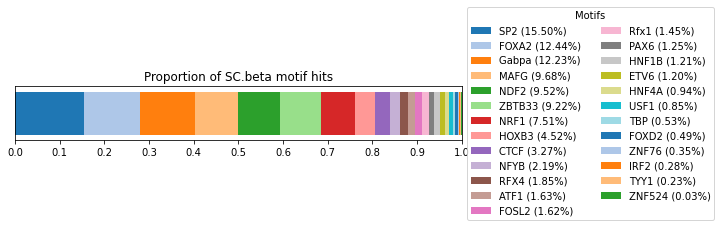

In [ ]:
# Create stacked bar chart with distinct colors
fig, ax = plt.subplots(figsize=(8, 1))
bottom = 0

for i, (motif, proportion) in enumerate(motif_props_df.iterrows()):
    #ax.bar(0, proportion, bottom=bottom, color=colors[i], label=motif)
    #bottom += proportion
    # switch to horizontal bar plot
    ax.barh(0, proportion, left=bottom, color=colors[i], label=motif)
    bottom += proportion

# Formatting
ax.set_xlim(0, 1)
ax.set_ylim(-0.5, 0.5)
ax.set_yticks([])
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_ylabel("")
ax.set_title("Proportion of SC.beta motif hits")

# Split legend into two columns
# Add 3 decimal places to the proportions (%)
handles, labels = ax.get_legend_handles_labels()
labels = [f"{l} ({motif_props_df.loc[l, 'Proportion']:.2%})" for l in labels]
ax.legend(handles, labels, loc="center left", bbox_to_anchor=(1, 0.5), title="Motifs", ncol=2)
#ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Motifs", ncol=2)

# Show plot
plt.show()


In [496]:
motifs

,SP2_HUMAN.H11MO.0.A,ZBTB33_MA0527.1,Gabpa_MA0062.2,ETV6_ETS_1,NRF1_MA0506.1_1,ATF1_HUMAN.H11MO.0.B,FOXA2_HUMAN.H11MO.0.A,NDF2_MOUSE.H11MO.0.A_1,NDF2_MOUSE.H11MO.0.A,HOXB3_MA0903.1,...,TYY1_HUMAN.H11MO.0.A,TBP_MA0108.2,ZNF76_HUMAN.H11MO.0.C,HNF4A_MOUSE.H11MO.0.A,IRF2_HUMAN.H11MO.0.A,ZNF76_HUMAN.H11MO.0.C_1,RFX4_RFX_2,Gabpa_MA0062.2_1,ZNF524_C2H2_2,total
peak_id,,,,,,,,,,,,,,,,,,,,,
0,1,0,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,1,1,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,8
2,0,0,1,2,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,6
3,0,3,3,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
4,1,0,0,0,3,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3
249996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
249997,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [497]:
motif_names = motifs.columns

In [500]:
motif_short_names = [motif_names[i].split("_")[0] for i in range(len(motif_names))]
motif_short_names

['SP2',
 'ZBTB33',
 'Gabpa',
 'ETV6',
 'NRF1',
 'ATF1',
 'FOXA2',
 'NDF2',
 'NDF2',
 'HOXB3',
 'CTCF',
 'FOSL2',
 'NFYB',
 'PAX6',
 'MAFG',
 'MAFG',
 'FOXA2',
 'PAX6',
 'MAFG',
 'FOXA2',
 'FOXA2',
 'HNF1B',
 'FOXD2',
 'Rfx1',
 'USF1',
 'NRF1',
 'TYY1',
 'TBP',
 'ZNF76',
 'HNF4A',
 'IRF2',
 'ZNF76',
 'RFX4',
 'Gabpa',
 'ZNF524',
 'total']

In [501]:
# Sum over columns with the same motif name
motifs_grouped = motifs.groupby(motif_short_names, axis=1).sum()
motifs_grouped

,ATF1,CTCF,ETV6,FOSL2,FOXA2,FOXD2,Gabpa,HNF1B,HNF4A,HOXB3,...,RFX4,Rfx1,SP2,TBP,TYY1,USF1,ZBTB33,ZNF524,ZNF76,total
peak_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,2,0,0,0,...,0,0,1,0,0,0,0,0,0,5
1,0,0,0,0,0,0,1,1,0,1,...,0,0,0,1,0,2,1,0,1,8
2,0,1,2,0,0,0,1,0,0,0,...,0,0,0,0,1,1,0,0,0,6
3,0,0,1,0,0,0,3,0,0,0,...,0,0,0,0,0,0,3,0,0,9
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
249996,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
249997,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,3


In [502]:
# drop total column
occ_df = motifs_grouped.drop(columns="total")

In [503]:
num_peaks = occ_df.shape[0]
num_motifs = occ_df.shape[1]

occ_mat = np.zeros((num_peaks, num_motifs), dtype=np.int16)
for i, m in enumerate(occ_df.columns):
    occ_mat[:,i] = occ_df[m]

occ_bin = (occ_mat > 0).astype(np.int32)
coocc = occ_bin.T @ occ_bin

In [508]:
matrix

array([[1.00000000e+00, 6.18552766e-02, 1.06230040e-01, 8.23526160e-02,
        1.78916971e-01, 3.93510064e-02, 2.08822013e-01, 5.65165868e-02,
        5.43454384e-02, 1.34376282e-01, 2.74156352e-02, 1.61965228e-01,
        1.46896052e-01, 1.55745302e-01, 1.88920906e-01, 7.35852079e-02,
        9.11134673e-02, 8.65531763e-02, 2.07361300e-01, 5.65848894e-02,
        8.66446604e-02, 9.40029513e-02, 1.96921847e-01, 1.39666241e-02,
        6.10551062e-02],
       [6.18552766e-02, 1.00000000e+00, 7.19491591e-02, 5.10545247e-02,
        1.47343582e-01, 2.46378043e-02, 1.85864731e-01, 4.03031991e-02,
        4.18790968e-02, 6.78367486e-02, 2.58904678e-02, 1.31685805e-01,
        1.37524006e-01, 7.41020893e-02, 1.47877681e-01, 3.73874611e-02,
        6.49621540e-02, 4.80772735e-02, 1.90859038e-01, 2.78827906e-02,
        2.64851063e-02, 3.93301772e-02, 1.56128278e-01, 6.40884748e-03,
        2.44749522e-02],
       [1.06230040e-01, 7.19491591e-02, 1.00000000e+00, 3.17474921e-02,
        6.7140

Text(0, 0.5, 'Motif j')

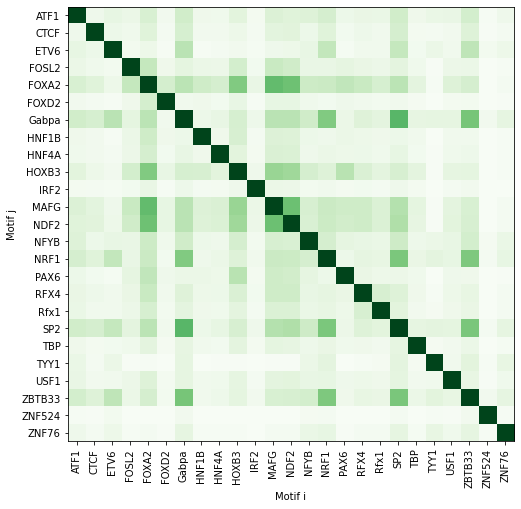

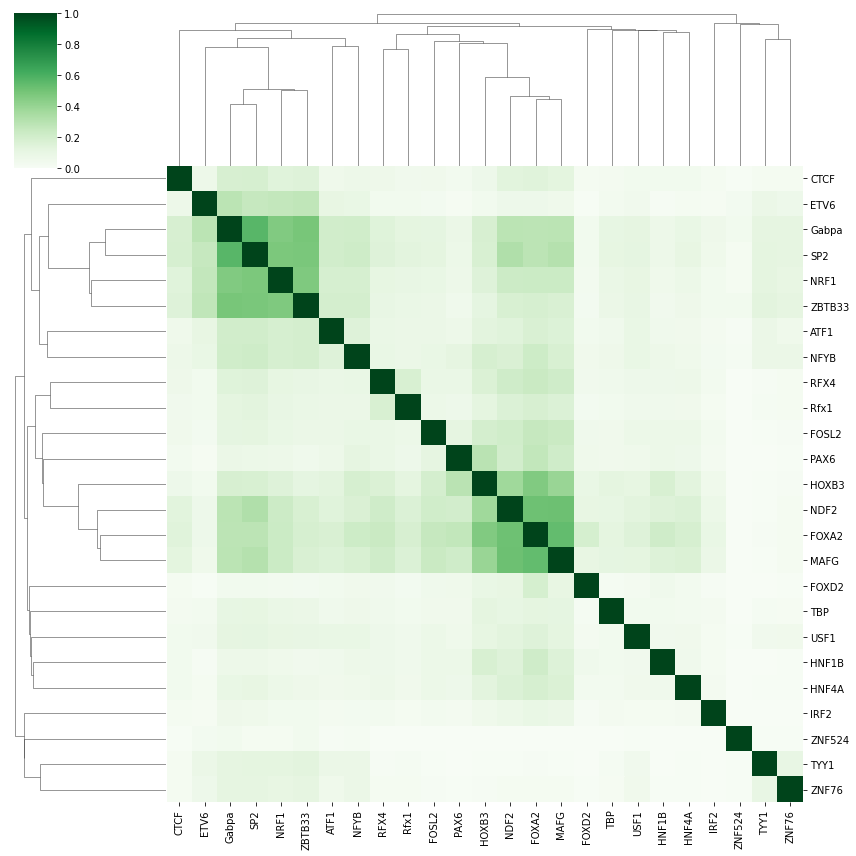

In [509]:
cov_norm = 1 / np.sqrt(np.diag(coocc))
matrix = coocc * cov_norm[:,None] * cov_norm[None,:]
motif_keys = occ_df.columns

fig, ax = plt.subplots(figsize=(8, 8))

# Cluster the matrix
sns.clustermap(matrix, row_cluster=True, col_cluster=True, cmap="Greens", figsize=(12, 12), xticklabels=motif_keys, yticklabels=motif_keys)

# Plot the heatmap
ax.imshow(matrix, interpolation="nearest", aspect="auto", cmap="Greens")

# Set axes on heatmap
ax.set_yticks(np.arange(len(motif_keys)))
ax.set_yticklabels(motif_keys)
ax.set_xticks(np.arange(len(motif_keys)))
ax.set_xticklabels(motif_keys, rotation=90)
ax.set_xlabel("Motif i")
ax.set_ylabel("Motif j")